# **Load and Inspect the Data**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the disaster dataset
disaster_df = pd.read_csv('/content/disasters.csv')

# Inspect the first few rows
print(disaster_df.head())
print(disaster_df.info())

print(disaster_df.columns)
print(disaster_df.describe())

                  Entity  Year   Deaths
0  All natural disasters  1900  1267360
1  All natural disasters  1901   200018
2  All natural disasters  1902    46037
3  All natural disasters  1903     6506
4  All natural disasters  1905    22758
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Entity  803 non-null    object
 1   Year    803 non-null    int64 
 2   Deaths  803 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 18.9+ KB
None
Index(['Entity', 'Year', 'Deaths'], dtype='object')
              Year        Deaths
count   803.000000  8.030000e+02
mean   1969.316314  8.121333e+04
std      32.339719  3.737054e+05
min    1900.000000  1.000000e+00
25%    1945.500000  2.695000e+02
50%    1975.000000  1.893000e+03
75%    1996.000000  1.036250e+04
max    2017.000000  3.706227e+06


In [ ]:
# Display the column names to check for 'Disaster_Type'
print(disaster_df.columns)


Index(['Entity', 'Year', 'Deaths'], dtype='object')


# **Data Preprocessing**

In [ ]:
# Check for missing values
print(disaster_df.isnull().sum())

# Drop duplicates
disaster_df.drop_duplicates(inplace=True)

# Convert Year to integer if it's not already
disaster_df['Year'] = disaster_df['Year'].astype(int)

# Option 1: Drop rows with missing values (if there aren't many)
# disaster_df.dropna(inplace=True)

# Option 2: Fill missing values only for numeric columns
numeric_cols = disaster_df.select_dtypes(include=[np.number]).columns
disaster_df[numeric_cols] = disaster_df[numeric_cols].fillna(disaster_df[numeric_cols].mean())

# Removing outliers using IQR method for a column like 'Deaths'
if 'Deaths' in disaster_df.columns:
    Q1 = disaster_df['Deaths'].quantile(0.25)
    Q3 = disaster_df['Deaths'].quantile(0.75)
    IQR = Q3 - Q1
    disaster_df = disaster_df[~((disaster_df['Deaths'] < (Q1 - 1.5 * IQR)) | (disaster_df['Deaths'] > (Q3 + 1.5 * IQR)))]

# Display the cleaned dataset
print("Cleaned Dataset:")
print(disaster_df.head())


Entity    0
Year      0
Deaths    0
dtype: int64
Cleaned Dataset:
                   Entity  Year  Deaths
3   All natural disasters  1903    6506
4   All natural disasters  1905   22758
12  All natural disasters  1913     882
13  All natural disasters  1914     289
15  All natural disasters  1916     300


# **Exploratory Data Analysis**

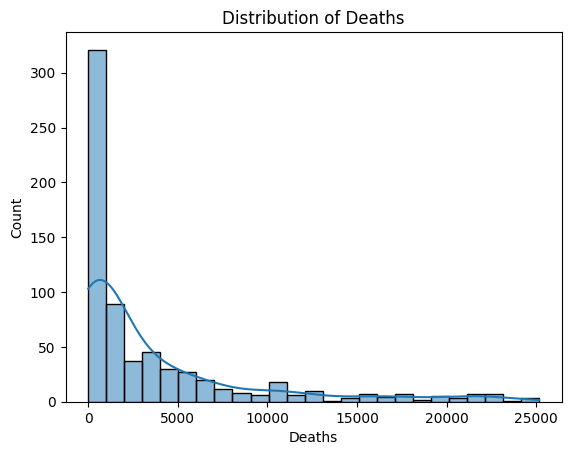

'Disaster_Type' column not found in the dataset.


In [ ]:
# Plotting the distribution of deaths
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of Deaths
sns.histplot(disaster_df['Deaths'], kde=True)
plt.title('Distribution of Deaths')
plt.show()

# Check if 'Disaster_Type' is the correct column name
if 'Disaster_Type' in disaster_df.columns:
    # Bar plot for Disaster Types
    disaster_df['Disaster_Type'].value_counts().plot(kind='bar')
    plt.title('Disaster Types Frequency')
    plt.show()
else:
    print("'Disaster_Type' column not found in the dataset.")


# **Correlation Analysis**

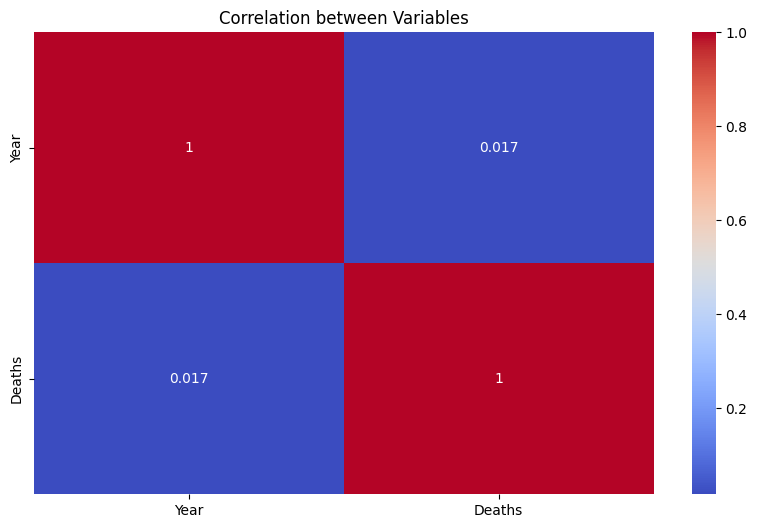

In [ ]:
# Select only numeric columns from the dataset
numeric_df = disaster_df.select_dtypes(include=['float64', 'int64'])

# Plot the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between Variables')
plt.show()


## **Feature Engineering**

In [ ]:
# Check if required columns exist before creating new features
if 'Deaths' in disaster_df.columns and 'Population' in disaster_df.columns:
    # 1. Disaster Severity Index (based on deaths and population)
    disaster_df['Severity_Index'] = (disaster_df['Deaths'] / disaster_df['Population']) * 100
else:
    print("Required columns for Severity Index are missing.")

if 'Entity' in disaster_df.columns and 'Year' in disaster_df.columns:
    # 2. Disaster Frequency by Year (count of disasters per year per region)
    disaster_df['Disaster_Frequency'] = disaster_df.groupby(['Entity', 'Year'])['Deaths'].transform('count')

    # 4. Time Since Last Disaster (difference in years between disasters in the same region)
    disaster_df['Time_Since_Last_Disaster'] = disaster_df.groupby('Entity')['Year'].diff().fillna(0)
else:
    print("Required columns for Disaster Frequency and Time Since Last Disaster are missing.")

if 'Year' in disaster_df.columns:
    # 3. Decade column (to track disasters by decade)
    disaster_df['Decade'] = (disaster_df['Year'] // 10) * 10
else:
    print("Required column 'Year' is missing.")

# 5. One-hot encoding for categorical variables (like Disaster_Type and Entity)
if 'Disaster_Type' in disaster_df.columns and 'Entity' in disaster_df.columns:
    disaster_df = pd.get_dummies(disaster_df, columns=['Disaster_Type', 'Entity'], drop_first=True)
else:
    print("Required columns for One-hot encoding are missing.")

# Final check on the dataframe
print("Feature Engineering completed successfully.")
print(disaster_df.head())


Required columns for Severity Index are missing.
Required columns for One-hot encoding are missing.
Feature Engineering completed successfully.
                   Entity  Year  Deaths  Disaster_Frequency  \
3   All natural disasters  1903    6506                   1   
4   All natural disasters  1905   22758                   1   
12  All natural disasters  1913     882                   1   
13  All natural disasters  1914     289                   1   
15  All natural disasters  1916     300                   1   

    Time_Since_Last_Disaster  Decade  
3                        0.0    1900  
4                        2.0    1900  
12                       8.0    1910  
13                       1.0    1910  
15                       2.0    1910  


# **Building a Machine Learning Model**

Prepare the Data for Modeling

In [ ]:
X = disaster_df.drop(columns=['Deaths'])  # Features
y = disaster_df['Deaths']  # Target variable


Train-Test Split Split the data into training and testing sets.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Feature Scaling Use standardization or normalization to scale the features.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Separate numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Scale only the numerical features
scaler = MinMaxScaler()
X_train_scaled_numerical = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled_numerical = scaler.transform(X_test[numerical_cols])

# Handle categorical features with OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # Updated argument
X_train_encoded_categorical = encoder.fit_transform(X_train[categorical_cols])
X_test_encoded_categorical = encoder.transform(X_test[categorical_cols])

# Combine scaled numerical and encoded categorical features
X_train_scaled = pd.concat([pd.DataFrame(X_train_scaled_numerical), pd.DataFrame(X_train_encoded_categorical)], axis=1)
X_test_scaled = pd.concat([pd.DataFrame(X_test_scaled_numerical), pd.DataFrame(X_test_encoded_categorical)], axis=1)

print("Preprocessing completed successfully.")


Preprocessing completed successfully.


Train a Gradient Boosting Regressor Model Use gradient boosting for regression.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)


GradientBoostingRegressor(random_state=42)

# **Model Evaluation**

Make Predictions Predict on the test set.

In [ ]:
y_pred = model.predict(X_test_scaled)


Evaluate the Model Use metrics like Mean Squared Error (MSE) and R² score to evaluate the model performance.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


Mean Squared Error: 20504319.23451427
R² Score: 0.35290791246800246


## **Visualization of Results**

Plot Actual vs Predicted Values Visualize how well the model predicted disaster deaths.

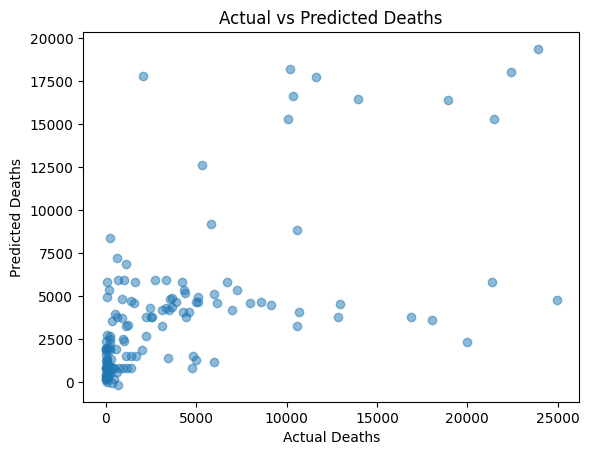

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Deaths')
plt.ylabel('Predicted Deaths')
plt.titlpe('Actual vs Predicted Deaths')
plt.show()


Plot Feature Importance Display the importance of each feature used by the model.

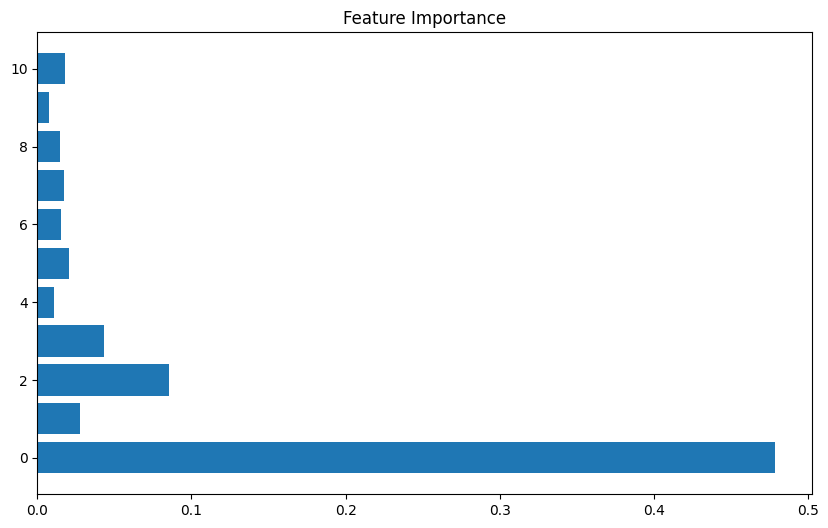

In [ ]:
# Assuming X_train_scaled was used for training the model
features = X_train_scaled.columns if isinstance(X_train_scaled, pd.DataFrame) else [f"Feature {i}" for i in range(X_train_scaled.shape[1])]

# Ensure the number of features matches the number of feature importances
if len(features) == len(model.feature_importances_):
    plt.figure(figsize=(10, 6))
    plt.barh(features, model.feature_importances_)
    plt.title('Feature Importance')
    plt.show()
else:
    print(f"Mismatch between number of features ({len(features)}) and feature importances ({len(model.feature_importances_)}).")
